In [1]:
import os
import tempfile
from typing import List
from dotenv import load_dotenv
from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFLoader ,Docx2txtLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_pinecone import PineconeVectorStore

from pinecone import ServerlessSpec ,Pinecone
from uuid import uuid4
import sys

d:\Agentic_RAG_Trading_Bot\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq

In [3]:
load_dotenv()

True

In [9]:
from pydantic import BaseModel
from langgraph.graph.message import add_messages
from typing import Annotated ,TypedDict

In [22]:
from langchain.tools import tool
from langchain_community.tools import TavilySearchResults
from langchain_community.tools.polygon.financials import PolygonFinancials
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain_community.tools.bing_search import BingSearchResults
os.environ["POLYGON_API_KEY"]=os.getenv("POLYGON_API_KEY")

In [39]:
from langgraph.graph import StateGraph,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt.tool_node import ToolNode,tools_condition
from langchain_core.messages import AIMessage ,HumanMessage
from typing_extensions import Annotated ,TypedDict
from IPython.display import Image ,display

In [ ]:
#Loading documents 

# Document loading, transformation and ingestion into Pinecone vector store.
uploaded_files=['D:/Agentic_RAG_Trading_Bot/fallback_data/stock_market_investing_guide.docx','D:/Agentic_RAG_Trading_Bot/fallback_data/stock_market.pdf','D:/Agentic_RAG_Trading_Bot/fallback_data/trading_basics.pdf']

documents = []
for uploaded_file in uploaded_files:
    root, ext = os.path.splitext(uploaded_file)
    if ext == ".pdf":
        loader = PyPDFLoader(uploaded_file)
        documents.extend(loader.load())
    else:
        loader = Docx2txtLoader(uploaded_file)
        documents.extend(loader.load())


In [5]:

# Text slitter
text_splitter = RecursiveCharacterTextSplitter(
                chunk_size=1000,
                chunk_overlap=200,
                length_function=len
            )

documents = text_splitter.split_documents(documents)

pinecone_client = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

In [6]:
documents [0]

Document(metadata={'source': 'D:/Agentic_RAG_Trading_Bot/fallback_data/stock_market_investing_guide.docx'}, page_content='Stock Market Investing Guide 2025\n\n\n\nBy\n\nVikram Singh \n\n\n\n\n\nContents \n\nCover page \n\nTitle Page \n\nIntroduction \n\nChapter 1. Set Clear Goals \n\nChapter 2. Educate Yourself \n\nChapter 3. Develop a Strategy \n\nChapter 4. Start Small \n\nChapter 5. Diversify Your Portfolio \n\nChapter 6. Understand Risk Tolerance \n\nChapter 7. Use Technology Wisely \n\nChapter 8. Stay Updated \n\nChapter 9. Invest for the Long Term \n\nChapter 10. Master Technical Analysis \n\nChapter 11. Understand Fundamental Analysis \n\nChapter 12. Control Emotions \n\nChapter 13. Monitor and Rebalance \n\nChapter 14. Avoid Herd Mentality \n\nChapter 15. Continue Learning \n\n\n\n\n\n\n\nIntroduction')

In [ ]:
index_name ="trading-bot"
if index_name not in [i.name for i in pinecone_client.list_indexes()]:
    pinecone_client.create_index(
    name=index_name,
    dimension=768,  # adjust if needed based on embedding model
    metric="cosine",
    spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

index = pinecone_client.Index(index_name)
vector_store = PineconeVectorStore(index=index, embedding=GoogleGenerativeAIEmbeddings(model="models/text-embedding-004"))
uuids = [str(uuid4()) for _ in range(len(documents))]

vector_store.add_documents(documents=documents, ids=uuids)

['314e6177-bd7e-4138-90c6-f55e7b2bb588',
 '220d7873-5ed1-4c77-a94e-02da577e97ed',
 '2eacaff8-66a2-489b-82d4-7813865c9998',
 '68cba77c-9b97-482e-8334-beb828066828',
 '487ecc3a-e04b-4334-8ca2-7a5299f51813',
 'ae78ba1e-39c4-4c4f-a3c7-9562699d61b8',
 '59ecc0fa-0ec7-4919-af3b-f285a71010e5',
 '99fea14c-d772-4d1c-b519-e91d020764a2',
 'ef9d3537-b0e3-43f6-9e45-4c32173bd4f7',
 '08853b46-5eaf-445f-9306-5120a98ce648',
 'be4d773e-3964-415d-a6de-9038930da42f',
 'f437f3bf-25e7-4b59-a3f4-1118f98c8f37',
 '8dc4bf4a-837b-4fd3-a420-9b1f53b07d31',
 '0e074e6a-65bc-4a4f-af25-eab6f46b09ba',
 '6764d5e5-d2e9-498e-8ee0-413c03bce381',
 'efa35a38-4c57-4522-9650-1a28883920e8',
 '3dbf8b9f-e434-4ae0-9e59-0e4db4abbbe5',
 '48899a98-63e3-4468-839a-17469cdf6930',
 'a393daee-0c2f-4b3c-8124-de0fd9f895f6',
 '529688b5-896d-4f9d-afd9-c33d31439b61',
 'c8568127-9380-4b41-b62b-940a5a2e8699',
 '540da58b-3ac8-436c-9f24-e5db15fdfa7d',
 '445001a7-6f5a-4560-afbb-f4f25ad3b773',
 'e17a82f3-6d2e-444e-9101-2be3366beb9c',
 '15159276-0818-

In [ ]:
# Schema Models 
class RagToolScheme(BaseModel):
    question: str

class QuestionRequest(BaseModel):
    question: str

In [63]:
##Tools Defination


# Retriver as a tool (Customised tool)
@tool(args_schema=RagToolScheme)
def retriever_tool(question):
    """this is retriever tool"""
    print('Retriver is called')
    pinecone_api_key=os.getenv("PINECONE_API_KEY")
    pc=Pinecone(api_key=pinecone_api_key)
    vector_store=PineconeVectorStore(index=pc.Index("trading-bot"),
                                     embedding=GoogleGenerativeAIEmbeddings(model="models/text-embedding-004"))
    
    retriever=vector_store.as_retriever(search_type="similarity_score_threshold",
                                        search_kwargs={"k":3 ,"score_threshold":0.5})
    retriever_result=retriever.invoke(question)

    return retriever_result

#IN Built Tool (search tool)
tavilytool = TavilySearchResults(
    max_results=2,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    )

#IN Built Tool (Financial stock search tool)
api_wrapper=PolygonAPIWrapper()
finanacials_tool=PolygonFinancials(api_wrapper=api_wrapper)

In [ ]:
#Retrieiver tool invoking
retriever_tool.invoke("tradingd basic rules")

[Document(id='a30717df-cc22-499b-9355-e1da52e3fdff', metadata={'author': 'Ashish', 'creationdate': '2010-02-01T20:12:11+05:30', 'creator': 'PDF Converter Elite', 'keywords': '', 'moddate': '2010-02-01T20:12:11+05:30', 'page': 0.0, 'page_label': '1', 'producer': 'PDF Converter Elite', 'source': 'D:/Agentic_RAG_Trading_Bot/fallback_data/stock_market.pdf', 'subject': '', 'title': '', 'total_pages': 15.0}, page_content='Basics Of Stock Market \nBy  RonakNangalia \nSohrabKothari'),
 Document(id='fc62a45c-472a-4527-aa74-7fae045396ec', metadata={'author': 'Ashish', 'creationdate': '2010-02-01T20:12:11+05:30', 'creator': 'PDF Converter Elite', 'keywords': '', 'moddate': '2010-02-01T20:12:11+05:30', 'page': 0.0, 'page_label': '1', 'producer': 'PDF Converter Elite', 'source': 'C:\\Users\\SUMANV~1\\AppData\\Local\\Temp\\tmpn0chzcij.pdf', 'subject': '', 'title': '', 'total_pages': 15.0}, page_content='Basics Of Stock Market \nBy  RonakNangalia \nSohrabKothari'),
 Document(id='50ea07c9-8a7e-4121-90

In [ ]:
#Tavily tool invoking
tavilytool.invoke("tradingd basic rules")

[{'title': "[PDF] Dennis Gartman's 22 “Rules of Trading",
  'url': 'https://www.sfu.ca/~poitras/Rules.pdf',
  'content': 'Dennis Gartman’s 22 “Rules of Trading 1. Never, under any circumstance add to a losing position.... ever! Nothing more need be said; to do otherwise will eventually and absolutely lead to ruin! 2. Trade like a mercenary guerrilla. We must fight on the winning side and be willing to change sides readily when one side has gained the upper hand. 3. Capital comes in two varieties: Mental and that which is in your pocket or account. Of the two types of capital, the mental is the more important and [...] bear runs. Reversal days on the charts signal the final exhaustion of the bullish or bearish forces that drove the market previously. Respect them, and respect even more "weekly" and "monthly," reversals. 12. Keep your technical systems simple. Complicated systems breed confusion; simplicity breeds elegance. 13. Respect and embrace the very normal 50-62% retracements that

In [ ]:
#polygon finacial  tool invoking

finanacials_tool.invoke({"query": "NVDA"} )

'[{"start_date": "2024-07-28", "end_date": "2025-07-27", "timeframe": "ttm", "fiscal_period": "TTM", "fiscal_year": "", "cik": "0001045810", "sic": "3674", "tickers": ["NVDA"], "company_name": "NVIDIA CORP", "financials": {"cash_flow_statement": {"net_cash_flow_from_investing_activities": {"value": -23887000000.0, "unit": "USD", "label": "Net Cash Flow From Investing Activities", "order": 400}, "net_cash_flow_from_financing_activities_continuing": {"value": -50080000000.0, "unit": "USD", "label": "Net Cash Flow From Financing Activities, Continuing", "order": 800}, "net_cash_flow_from_operating_activities_continuing": {"value": 77035000000.0, "unit": "USD", "label": "Net Cash Flow From Operating Activities, Continuing", "order": 200}, "net_cash_flow": {"value": 3068000000.0, "unit": "USD", "label": "Net Cash Flow", "order": 1100}, "net_cash_flow_continuing": {"value": 3068000000.0, "unit": "USD", "label": "Net Cash Flow, Continuing", "order": 1200}, "net_cash_flow_from_operating_activi

In [64]:
#Tools
tools=[retriever_tool,finanacials_tool,tavilytool]
# Loaing the LLM model
llm=groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b",api_key=os.getenv("GROQ_API_KEY"))

#Binding LLM with tools
llm_with_tools=llm.bind_tools(tools=tools)

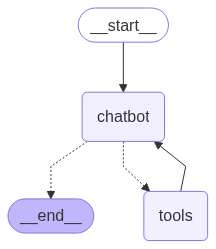

In [65]:
#Agentic graph 


class State(TypedDict):
    messages: Annotated[list ,add_messages]

# Chatbot Node
def chatbot_node(state:State):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder=StateGraph(State)
tool_node=ToolNode(tools=tools)
graph_builder.add_node("chatbot",chatbot_node)
graph_builder.add_node("tools", tool_node)
        
graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot",tools_condition)
graph_builder.add_edge("tools","chatbot")

graph = graph_builder.compile()

# Show the workflow
display(Image(graph.get_graph().draw_mermaid_png()))

In [66]:
graph.invoke({"messages":["tradingd basic rules"]})

{'messages': [HumanMessage(content='tradingd basic rules', additional_kwargs={}, response_metadata={}, id='d685b9dd-2a0e-4ad5-8ad3-3a29acd15d10'),
  AIMessage(content='', additional_kwargs={'reasoning_content': '<tool_call>{"name":"retriever_tool","arguments":{"question":"What are the basic rules of tradingd?"}}</tool_call>'}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 284, 'total_tokens': 315, 'completion_time': 0.112853301, 'prompt_time': 0.034902702, 'queue_time': 0.047397688, 'total_time': 0.147756003}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--2b6ee889-73bb-4e7f-b99e-fcc1afc3b0b6-0', usage_metadata={'input_tokens': 284, 'output_tokens': 31, 'total_tokens': 315})]}

In [68]:
graph.invoke({"messages":["weather Pune"]})

{'messages': [HumanMessage(content='weather Pune', additional_kwargs={}, response_metadata={}, id='42fd9e6b-6a52-4ca7-b25b-4104e271dcd9'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Alright, the user is asking about the weather in Pune. Since I can\'t access real-time data, I should suggest using a tool that can fetch current information. The Tavily search tool seems appropriate for this because it\'s designed for up-to-date and accurate results. I\'ll format the tool call with the query "weather Pune" to get the latest information.\n', 'tool_calls': [{'id': 'b2jtcbnrr', 'function': {'arguments': '{"query":"weather Pune"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 281, 'total_tokens': 384, 'completion_time': 0.426291396, 'prompt_time': 0.034486103, 'queue_time': 0.044130697, 'total_time': 0.460777499}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprin

In [70]:
graph.invoke({"messages":["Stock Market Investing Guide 2025"]})

Retriver is called


{'messages': [HumanMessage(content='Stock Market Investing Guide 2025', additional_kwargs={}, response_metadata={}, id='26414ab4-f765-4adb-9cdc-708e56b227ca'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, I need to figure out how to respond to the user\'s request about the "Stock Market Investing Guide 2025." They mentioned using the tools provided, which are retriever_tool, polygon_financials, and tavily_search_results_json. \n\nFirst, I should determine the best tool for the job. Since the user is asking for a guide, it\'s likely looking for comprehensive information, possibly from recent sources. The retriever_tool seems like it\'s designed for fetching information based on a question, so that might be the most appropriate here.\n\nI\'ll structure the function call with the name "retriever_tool" and the question as "Stock Market Investing Guide 2025." This should retrieve the relevant information the user is seeking.\n', 'tool_calls': [{'id': 'y3qz8ba0j', '

In [73]:
from fastapi import FastAPI ,UploadFile ,File,Request
from fastapi.middleware.cors import CORSMiddleware
from typing import List
from starlette.responses import JSONResponse




app=FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # set specific origins in prod
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],

)

In [74]:
@app.post("/query")
async def query_chatbot(request:QuestionRequest):
    try:
        

        # Assuming request is a pydantic object like: {"question": "your text"}
        messages={"messages":[request.question]}

        result=graph.invoke(messages)

        #if result is dict with messages

        if isinstance(result, dict) and "messages" in result:
            final_output = result["messages"][-1].content  # Last AI response
        
        else:
            final_ouput=str(result)

        return  {"answer": final_output}
    except Exception as e:
        return JSONResponse(status_code=500, content={"error": str(e)})

In [75]:
import nest_asyncio
import uvicorn

if __name__ == "__main__":
    nest_asyncio.apply()
    uvicorn.run(app)

INFO:     Started server process [33512]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:62435 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:62435 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:62442 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:62442 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:52473 - "POST /query HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:51846 - "POST /query HTTP/1.1" 200 OK
INFO:     127.0.0.1:51449 - "POST /query HTTP/1.1" 200 OK
INFO:     127.0.0.1:49667 - "POST /query HTTP/1.1" 500 Internal Server Error
INFO:     127.0.0.1:49371 - "POST /query HTTP/1.1" 500 Internal Server Error
INFO:     127.0.0.1:49375 - "POST /query HTTP/1.1" 200 OK
INFO:     127.0.0.1:60557 - "POST /query HTTP/1.1" 500 Internal Server Error
INFO:     127.0.0.1:56929 - "POST /query HTTP/1.1" 200 OK
INFO:     127.0.0.1:56931 - "POST /query HTTP/1.1" 500 Internal Server Error
INFO:     127.0.0.1:56797 - "POST /query HTTP/1.1" 500 Internal Server Error
INFO:     127.0.0.1:56800 - "POST /query HTTP/1.1" 500 Int

INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [33512]
